## Aim
Given different features the Goal is to predict the insurance charges for an individual.

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,activations

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots as plots

## Read the data
We are using a previously processed insurance dataset. For having a glance at the pre-processing visit the [Notebook](./Regression_InsuranceDataset.ipynb)

In [3]:
data=pd.read_csv("datasets/insurance_processed.csv")
data.sample(10)

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
824,1.480485,-1.040599,-0.908614,0,0,0,1,0,0,12523.60480
21,-0.655551,0.284880,-0.078767,1,0,0,0,0,1,4149.73600
1040,-0.299545,-0.432814,-0.908614,1,1,0,1,0,0,20234.85475
931,-0.014740,0.301285,-0.078767,1,0,0,0,0,1,6238.29800
1199,-0.584350,-0.797813,0.751079,1,0,0,0,0,1,4934.70500
532,1.409283,-0.158040,0.751079,0,0,0,0,1,0,12925.88600
1185,0.412467,-1.165273,0.751079,0,0,1,0,0,0,8603.82340
570,-0.584350,-0.256467,-0.908614,1,0,0,0,0,1,3761.29200
806,0.056461,1.764561,-0.078767,1,0,0,1,0,0,28476.73499
1318,-0.299545,1.484045,2.410772,0,0,1,0,0,0,19496.71917


In [4]:
data.shape

(1338, 10)

In [5]:
# Extract the feature matrix and the output matrix
features=data.drop(labels=['charges'],axis=1)
target=data['charges']

## Splitting the Data

In [7]:
x_train,x_test,y_train,y_test=train_test_split(features,target,
                                              test_size=0.2,
                                              random_state=1)

x_train.shape,x_test.shape

((1070, 9), (268, 9))

## Custom Layer

In [8]:
# Before defining a Custom Model let's define a Custom layer.
class MyDense(layers.Layer):
    
    def __init__(self,units,activation=None,**kwargs):
        super(MyDense,self).__init__(**kwargs)
        self.units=units
        self.activation=activations.get(activation)
        
    # Initializing weights for layers
    def build(self,input_shape):
        # Number of features
        input_dim=input_shape[-1]
        
        # Initializing weight without biases
        self.w=self.add_weight(shape=(input_dim,self.units))
        
    # Function for forward Pass
    def call(self,input_tensor):
        output=tf.matmul(input_tensor,self.w)
        
        if self.activation is not None:
            output=self.activation(output)
        
        return output
    
    def compute_output_shape(self,input_shape):
        output_shape=list(input_shape)
        output_shape[-1]=self.units
        
        return tuple(output_shape)
    
    # Serializing the layers
    def get_config(self):
        config=super(MyDense,self).get_config()
        current_config={
            'units':self.units,
            'activation':activations.serialize(self.activation)
        }
        
        config.update(current_config)
        
        return config

## Buidling a Sequential model using Custom Layer

In [11]:
def build_model():
    model=tf.keras.Sequential([
        MyDense(64,activation='elu',input_shape=[x_train.shape[1]]),
        MyDense(32,activation='elu'),
        
        layers.Dropout(0.2),
        
        MyDense(16,activation='elu'),
        MyDense(1)
    ])
    
    model.compile(loss='mse',
                 optimizer=tf.keras.optimizers.RMSprop(0.001),
                 metrics=['mae','mse'])
    
    return model

In [12]:
sequential_model=build_model()

sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_4 (MyDense)         (None, 64)                576       
_________________________________________________________________
my_dense_5 (MyDense)         (None, 32)                2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
my_dense_6 (MyDense)         (None, 16)                512       
_________________________________________________________________
my_dense_7 (MyDense)         (None, 1)                 16        
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________


## Training a Custom model

In [13]:
n_epochs=1000
training_hist=sequential_model.fit(x_train,
                                  y_train,
                                  epochs=n_epochs,
                                  validation_split=0.2,
                                  verbose=False,
                                  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317029792.0000,  mae:13316.9463,  mse:317029792.0000,  val_loss:336044064.0000,  val_mae:12875.4160,  val_mse:336044064.0000,  
....................................................................................................
Epoch: 100, loss:32468626.0000,  mae:3620.5325,  mse:32468626.0000,  val_loss:23923844.0000,  val_mae:3003.5544,  val_mse:23923844.0000,  
....................................................................................................
Epoch: 200, loss:27751438.0000,  mae:3308.8005,  mse:27751438.0000,  val_loss:21582974.0000,  val_mae:2616.5151,  val_mse:21582974.0000,  
....................................................................................................
Epoch: 300, loss:27943400.0000,  mae:3267.9763,  mse:27943400.0000,  val_loss:20922726.0000,  val_mae:2464.1118,  val_mse:20922726.0000,  
....................................................................................................
Epoch: 400, loss:26430956.0000,  ma

## Plotting the loss for Training and Validation

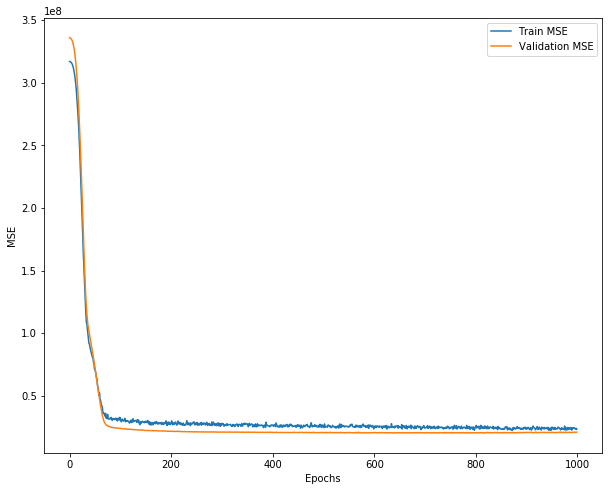

In [18]:
train_mse=training_hist.history['mse']
val_mse=training_hist.history['val_mse']

epoch_range=range(n_epochs)

plt.figure(figsize=(10,8))
plt.plot(epoch_range,train_mse,label='Train MSE')
plt.plot(epoch_range,val_mse,label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

## Predictions

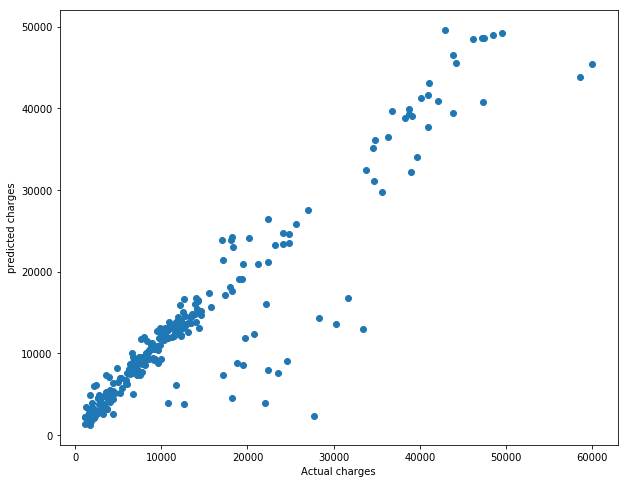

In [19]:
y_pred=sequential_model.predict(x_test)

plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual charges')
plt.ylabel('predicted charges')
plt.show()

In [20]:
# Now let's calculate the r2 value
r2_score(y_test,y_pred)

0.8729506537393948

## Building a Custom model using model subclassing

In [21]:
class CustomRegressionModel(tf.keras.Model):
    
    def __init__(self,input_shape,layer_units=[8,4],activation='relu'):
        super(CustomRegressionModel,self).__init__()
        
        assert len(layer_units)>0
        
        self.input_layer=MyDense(layer_units[0],
                                activation=activation,
                                input_shape=[input_shape])
        
        self.hidden_layers=[]
        
        for i in range(1,len(layer_units)):
            self.hidden_layers.append(MyDense(layer_units[i],
                                             activation=activation))
            
        self.output_layer=MyDense(1)
        
    # Forward Pass
    def call(self,input_tensor):
        x=self.input_layer(input_tensor)
        
        for layer in self.hidden_layers:
            x=layer(x)
            
        output=self.output_layer(x)
        
        return output

In [22]:
# Instantiate the class obj
custom_model=CustomRegressionModel(x_train.shape[1],[64,32,16],'elu')

# we need to make 1 pass to view the summary of the model
custom_model(tf.zeros([5,x_train.shape[1]]))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [23]:
custom_model.summary()

Model: "custom_regression_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_8 (MyDense)         multiple                  576       
_________________________________________________________________
my_dense_9 (MyDense)         multiple                  2048      
_________________________________________________________________
my_dense_10 (MyDense)        multiple                  512       
_________________________________________________________________
my_dense_11 (MyDense)        multiple                  16        
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________


In [24]:
# let's configure the model
custom_model.compile(loss='mse',
                    optimizer=tf.keras.optimizers.RMSprop(0.001),
                    metrics=['mse'])

## Training a Custom Model

In [27]:
training_hist=custom_model.fit(x_train,
                              y_train,
                              epochs=n_epochs,
                              validation_split=0.2,
                              verbose=False,
                              callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:316831424.0000,  mse:316831424.0000,  val_loss:335780576.0000,  val_mse:335780576.0000,  
....................................................................................................
Epoch: 100, loss:26472846.0000,  mse:26472846.0000,  val_loss:24591776.0000,  val_mse:24591776.0000,  
....................................................................................................
Epoch: 200, loss:23179066.0000,  mse:23179066.0000,  val_loss:21800270.0000,  val_mse:21800270.0000,  
....................................................................................................
Epoch: 300, loss:22057126.0000,  mse:22057126.0000,  val_loss:21055748.0000,  val_mse:21055748.0000,  
....................................................................................................
Epoch: 400, loss:21378738.0000,  mse:21378738.0000,  val_loss:20912990.0000,  val_mse:20912990.0000,  
..............................................................................

## Plotting the MSE via HistoryPlotter

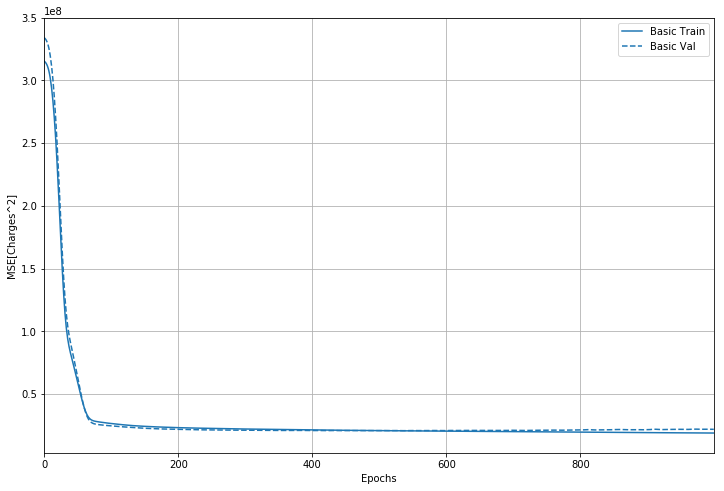

In [30]:
plotter=plots.HistoryPlotter(smoothing_std=2)

plt.figure(figsize=(12,8))

plotter.plot({'Basic':training_hist},metric='mse')
plt.ylabel('MSE[Charges^2]')
plt.show()

## Predictions on Custom model

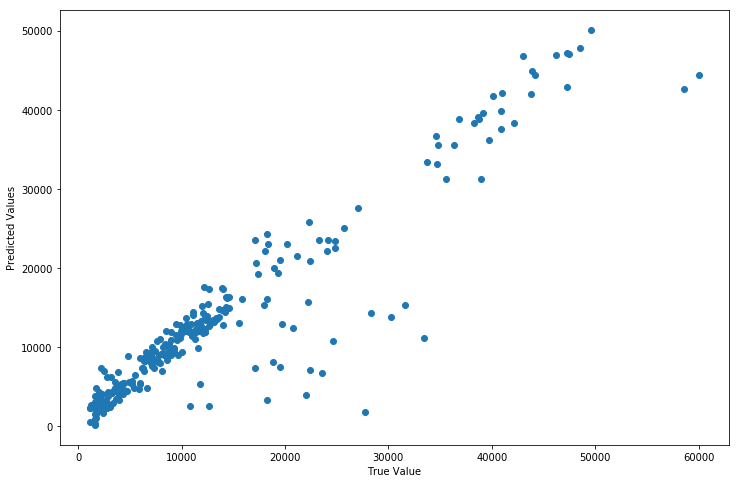

In [31]:
y_pred=custom_model.predict(x_test)

plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Values')
plt.show()

In [32]:
# Calculating the r2 value
r2_score(y_test,y_pred)

0.8675453346178855

Hence, we can say the the model performs almost the same as the Sequential model.

## Saving weights and using it later
(Possible because we have serialized our model layers in MyDense)

In [33]:
custom_model.save_weights('my_models/custom_model.h5',save_format='h5')

In [37]:
# Create a new model
new_model=CustomRegressionModel(x_train.shape[1],[64,32,16],'elu')

new_model(tf.zeros([5,x_train.shape[1]]))

new_model.compile(loss='mse',
                 optimizer=tf.keras.optimizers.RMSprop(0.001),
                 metrics=['mse'])

In [38]:
# Loading weights in this model
new_model.load_weights('my_models/custom_model.h5')

In [39]:
# Making predictions without training and loading weights
y_pred=new_model.predict(x_test.values)

r2_score(y_test,y_pred)

0.8675453346178855

Hence, we get the same score as before.